In [2]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=1cbc1406372f3b5ab0568cf4e7112a324444d252af2ecf3ad6e32f3a3fc70bde
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [3]:
import os
import torch
import torchviz
import yaml
import argparse
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pickle
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Working device is: {device}')

from AE import *

Working device is: cuda


In [4]:
parser = argparse.ArgumentParser(description='Generic runner for models')
parser.add_argument('--config', '-c',
                    dest="filename",
                    metavar='FILE',
                    help='path to the config file',
                    default='./configs/ae.yaml')

args = parser.parse_args(args=[])

with open(args.filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

In [5]:
config

{'data_params': {'epochs': 50,
  'patch_size': 64,
  'train_batch_size': 64,
  'val_batch_size': 64},
 'model_params': {'in_channels': 1, 'latent_dim': 6},
 'models_names': {'name1': 'SAEC', 'name2': 'SAEL', 'name3': 'VAE'},
 'saec_params': {'LR': 0.0001,
  'beta1': 0.935,
  'beta2': 0.965,
  'loss_weight': 2.86,
  'manual_seed': 42,
  'weight_decay': 0.008},
 'sael_params': {'LR': 0.0001,
  'beta1': 0.919,
  'beta2': 0.964,
  'loss_weight': 3.1,
  'manual_seed': 42,
  'weight_decay': 0.006},
 'vae_params': {'LR': 0.0001,
  'kld_weight': 0.00025,
  'manual_seed': 42,
  'scheduler_gamma': 0.95,
  'weight_decay': 0.0}}

In [6]:
with open('./data/train_data.pkl', 'rb') as h:
    data = pickle.load(h)
a, c = np.array(data[0]), np.array(data[1])

scaler = StandardScaler()  # MinMaxScaler()
scaler.fit(a)
a = scaler.transform(a)

a, c = torch.tensor(a), torch.tensor(c)
c = c.view(-1, config['model_params']['in_channels'], 100, 3)

random_indexes = torch.randint(0, c.shape[0], (int(0.005 * c.shape[0]),))
z = torch.zeros(c.shape[0])
z = z.index_fill(0, random_indexes, 1)
z = z > 0
train, validate = c[~z, :, :, :], c[z, :, :, :]
train_a, validate_a = a[~z, :], a[z, :]
random_shuffle = torch.randint(0, train.shape[0], (train.shape[0],))
train = train[random_shuffle]
train_a = train_a[random_shuffle]

train_a, validate_a = DataLoader(train_a, batch_size=config['data_params']['train_batch_size'], shuffle=False), \
                      DataLoader(validate_a, batch_size=config['data_params']['val_batch_size'], shuffle=False)
train, validate = DataLoader(train, batch_size=config['data_params']['train_batch_size'], shuffle=False), \
                  DataLoader(validate, batch_size=config['data_params']['val_batch_size'], shuffle=False)


In [7]:
with open('./data/test_data_2mm_p100.pkl', 'rb') as H:
    test = pickle.load(H)
    X_test, Y_test, Y_ = np.array(test[0]), np.array(test[1]), np.array(test[2])
    X_test = scaler.transform(X_test)
    X_test = torch.tensor(X_test)
    Y_test = torch.tensor(Y_test).view(-1, config['model_params']['in_channels'], 100, 3)

In [20]:
def train_sae(model, train, train_a, val, val_a, lr=config['saec_params']['LR'], epochs=config['data_params']['epochs']):
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = model.loss_latent_constraints  # loss_function
    train_losses = []
    val_losses = []
    threshold = torch.tensor(0.0250)
    prog_bar = tqdm(range(0, epochs))
    for i in prog_bar:
        # Run the training batches
        for b, (x, a_) in enumerate(zip(train, train_a)):
            b += 1
            # Apply the model
            x = x.float().to(device)
            results = model.forward(x)  # results = [decoded, input, z]
            loss_regu = criterion(*results,
                                  a=a_.float().to(device))
            loss_req = loss_regu['Reconstruction_Loss']
            loss = loss_regu['loss']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if b % 50 == 0:
                prog_bar.set_description(f'epoch: {i:2}  batch: {b:4} [{64 * b:6}/{c.shape[0]}]  loss: {loss.item():10.8f} '
                      f'loss reconstruction: {loss_req.item():10.8f}   loss a torque: {loss_regu["a torque"].item():10.8f}'
                      f' loss a force: {loss_regu["a force"].item():10.8f}')
        train_losses.append(loss.data.cpu().numpy())
        if loss_regu['latent loss'] < threshold:
            torch.save(model, f'check_point_{model. __class__. __name__}.pt')
            threshold = loss_regu['latent loss']
            print(f'Saved model: {threshold}')

        # check validation set:
        with torch.no_grad():
            for b, (t, a_val) in enumerate(zip(val, val_a)):
                t_ = t.float().to(device)
                y_val = model.forward(t_)
                loss2 = criterion(*y_val, a=a_val.float().to(device))['loss']
        val_losses.append(loss2.data.cpu().numpy())

    print(f'epoch: {i:3}  loss: {loss.item():10.8f}')  # print the last line
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed
    print('Finished Training')
    return model, loss, train_losses, val_losses


def train_vae(model, train, train_a, val, val_a, lr=config['saec_params']['LR'], epochs=config['data_params']['epochs']):
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = model.loss_function  # loss_function
    threshold = torch.tensor(0.0250)
    train_losses = []
    val_losses = []
    prog_bar = tqdm(range(0, epochs))
    for i in prog_bar:
        # Run the training batches
        for b, (x, a_) in enumerate(zip(train, train_a)):
            b += 1
            # Apply the model
            x = x.float().to(device)
            results = model.forward(x)  # results = [z, input, mu, log_var]
            loss_regu = criterion(*results,
                                  M_N=config['vae_params']['kld_weight'])
            loss_req = torch.sqrt(loss_regu['Reconstruction_Loss'])
            loss_kld = torch.sqrt(loss_regu['KLD'])
            loss = torch.sqrt(loss_regu['loss'])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if b % 100 == 0:
                prog_bar.set_description(f'epoch: {i:2}  batch: {b:4} [{64 * b:6}/{c.shape[0]}]  loss: {loss.item():10.8f} '
                      f'loss reconstruction: {loss_req.item():10.8f} loss KLD: {loss_kld.item():10.8f}')
        train_losses.append(loss.data.cpu().numpy())
        if loss_regu['loss'] < threshold:
            torch.save(model, f'check_point_{model. __class__. __name__}.pt')
            threshold = loss_regu['loss']
            print(f'Saved model: {threshold}')

        # check validation set:
        with torch.no_grad():
            losses = []
            for b, (t, a_val) in enumerate(zip(val, val_a)):
                t_ = t.float().to(device)
                y_val = model.forward(t_)
                loss2 = torch.sqrt(criterion(*y_val, M_N=1.)['Reconstruction_Loss'])
                losses.append(loss2.data.cpu().numpy())
        val_losses.append(np.mean(losses))
        print(f'Validation Loss of epoch {i}: {1000 * np.mean(losses):.4f} mm')

    print(f'epoch: {i:3}  loss: {1000 * loss.item():.4f} mm')  # print the last line
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed
    print('Finished Training')
    return model, loss, train_losses, val_losses


def _eval(model, y_test, a_test, criterion):
    with torch.no_grad():
        loss_ = []
        for (a_, y_) in zip(a_test, y_test):
            a_ = a_.float().to(device)
            y_ = y_.float().to(device)
            y_val = model.forward(y_)
            loss = criterion(*[y_val[0], y_, a_], a=a_)['Reconstruction_Loss']
            loss_.append(loss.data.cpu().numpy())
        print(f'RMSE: {1000 * np.mean(loss_):.4f} mm')
    return y_val, loss_


def _eval_decoder(model, a_test, y_test, criterion):
    with torch.no_grad():
        loss_ = []
        forces = []
        for (a_, y_) in zip(a_test, y_test):
            a_ = a_.float().to(device)
            y_ = y_.float().to(device)
            # pred_forces, _ = model.encode(y_)
            # forces.append(pred_forces)
            y_pred = model.decode(a_)
            loss = criterion(*[y_pred, y_, a_], a=a_)['Reconstruction_Loss']
            loss_.append(loss.data.cpu().numpy())

        print(f'RMSE: {1000 * np.mean(loss_):.4f} mm')
    return y_pred, loss_, forces


def _eval_vae(model, y_test, a_test, criterion):
    with torch.no_grad():
        loss_ = []
        for (a_, y_) in zip(a_test, y_test):
            a_ = a_.float().to(device)
            y_ = y_.float().to(device)
            # print(f't device: {t.get_device()}')
            y_val = model.forward(y_)
            loss = torch.sqrt(criterion(*y_val, M_N=1.)['Reconstruction_Loss'])
            loss_.append(loss.data.cpu().numpy())

        print(f'RMSE: {1000 * np.mean(loss_):.4f} mm')
    return y_val, loss_


def get_error(P1, P2):
    if P1.shape[0] == P2.shape[0]:
        return np.array([np.linalg.norm(x1 - x2) for x1, x2 in zip(P1, P2)])

    err = []
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(P2)
    for p1 in P1:
        _, i = nbrs.kneighbors(p1.reshape((1, -1)))
        i = i[0][0]
        p = P2[i]
        err.append(np.linalg.norm(p1 - p))

    return np.array(err)

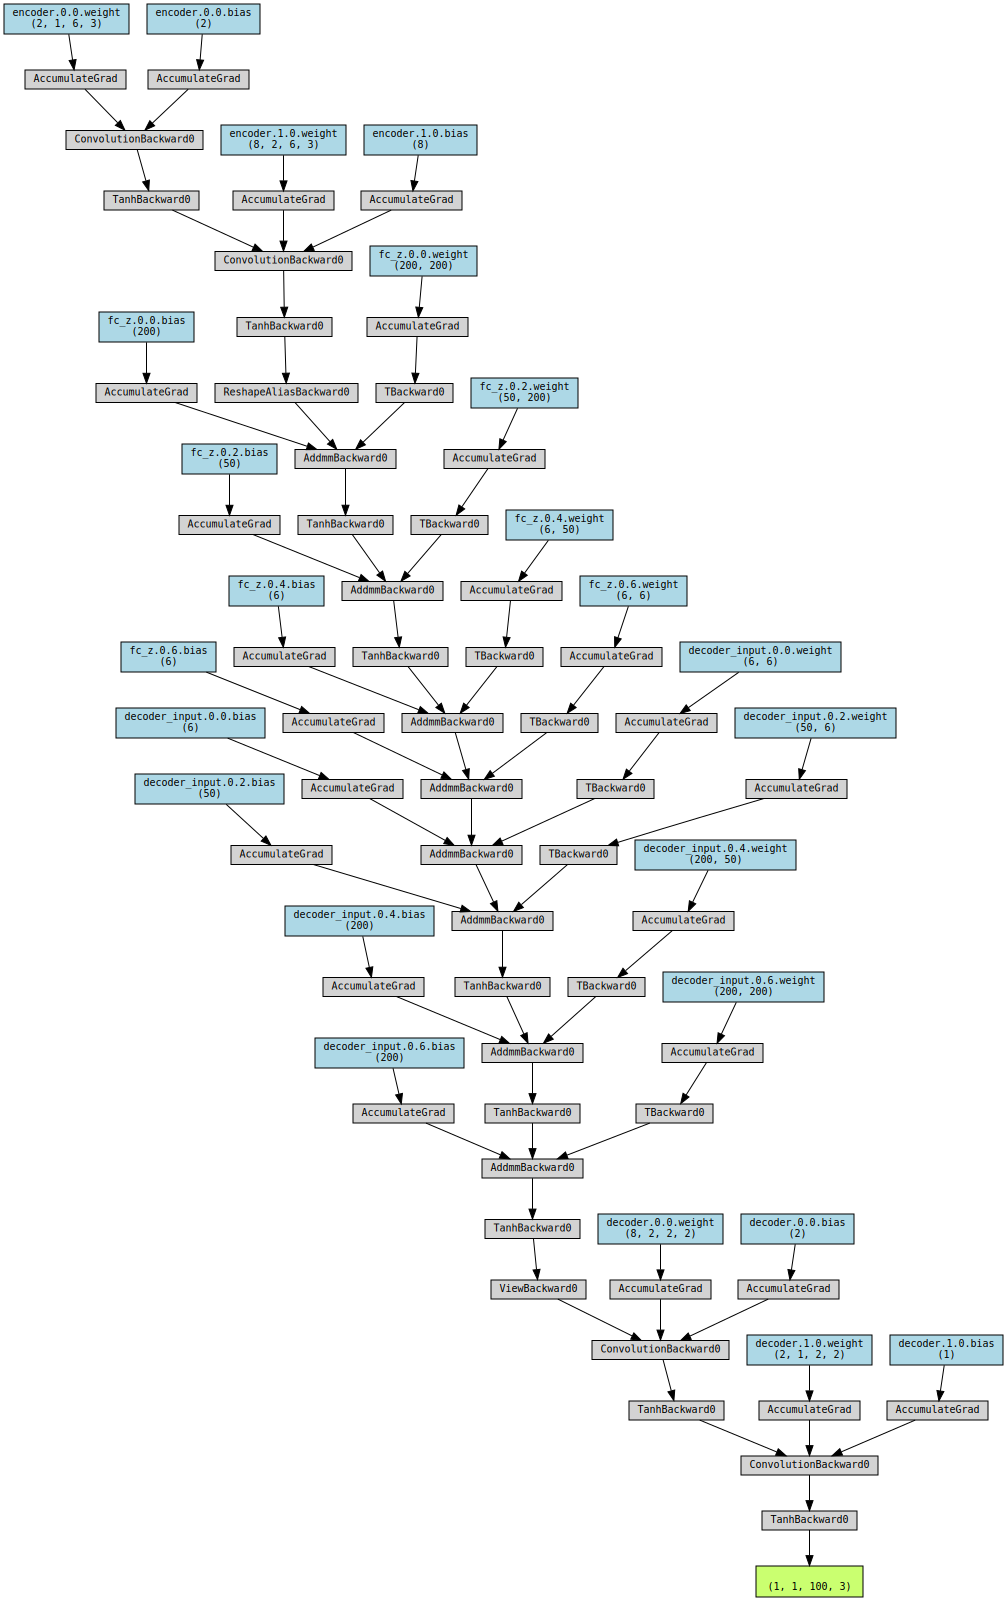

In [9]:
model = SAEC(loss_weight=config['saec_params']['loss_weight'], beta1=config['saec_params']['beta1'], beta2=config['saec_params']['beta2'],
            weight_decay=config['saec_params']['weight_decay'])
model = model.to(device)
x = torch.zeros(1, 1, 100, 3, dtype=torch.float, requires_grad=False)
x = x.float().to(device)
results = model.forward(x)

# out = model.forward(train.dataset[0].float().to(device))
torchviz.make_dot(results[0], params=dict(model.named_parameters()))  # plot graph of variable, not of a nn.Module

  0%|          | 0/50 [00:00<?, ?it/s]

Saved model: 0.023392703384160995
Saved model: 0.018961453810334206
Saved model: 0.017566759139299393
Saved model: 0.016854319721460342
Saved model: 0.01632058620452881
Saved model: 0.015883546322584152
Saved model: 0.01551048830151558
Saved model: 0.015179182402789593
Saved model: 0.014876244589686394
Saved model: 0.01459534652531147
Saved model: 0.014333689585328102
Saved model: 0.014090150594711304
Saved model: 0.013864478096365929
Saved model: 0.01365647278726101
Saved model: 0.013465465977787971
Saved model: 0.013290359638631344
Saved model: 0.013129939325153828
Saved model: 0.012983166612684727
Saved model: 0.012849215418100357
Saved model: 0.012727427296340466
Saved model: 0.012617154978215694
Saved model: 0.012517668306827545
Saved model: 0.012428129091858864
Saved model: 0.012347592040896416
Saved model: 0.01227500755339861
Saved model: 0.012209296226501465
Saved model: 0.012149403803050518
Saved model: 0.012094350531697273
Saved model: 0.012043294496834278
Saved model: 0.0119

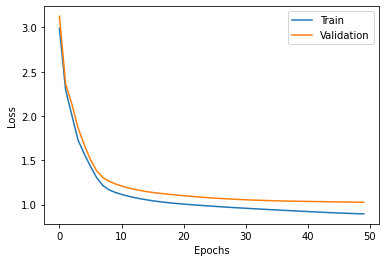

In [21]:
def run_sae():

    model = SAEC(loss_weight=config['saec_params']['loss_weight'], beta1=config['saec_params']['beta1'], 
                 beta2=config['saec_params']['beta2'], weight_decay=config['saec_params']['weight_decay'])
    model = model.to(device)
    model, loss, train_losses, validate_losses = train_sae(model, train, train_a, validate, validate_a, lr=config['saec_params']['LR'])
    fig = plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(validate_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('./data/SAEC_train.png', dpi=1200)
    plt.show()

run_sae()


In [125]:
# test SAEC:

model_best = torch.load('check_point_SAEC.pt', map_location=device)

Acc = []
m_err = []
f_err = []
timer = []
# y = Y_test.squeeze().detach().numpy()

model_best = model_best.to('cpu')
for im in tqdm(range(X_test.shape[0])):
    # print('Processing rod conf. number %d.'%(im))
    a, p = X_test[im, :], Y_test[im, :, :].reshape((-1, 3))

    ts = time.time()
    with torch.no_grad():
        p_predict = model_best.decode(a.float().view(1, 6))
        timer.append(time.time() - ts)
        a_predict = model_best.encode(p.float().view(1, -1, 100, 3))
        p_predict = p_predict.view(-1, 3)
        p_predict = p_predict.numpy()
        a_predict = a_predict.view(-1, 6)
        a_predict = a_predict.numpy()
    
    err = get_error(p, p_predict)
    Acc.append(np.mean(err))
    m_err.append(np.linalg.norm(scaler.inverse_transform(a_predict).squeeze()[:3] - scaler.inverse_transform(a.numpy().reshape(1, -1)).squeeze()[:3]))
    f_err.append(np.linalg.norm(scaler.inverse_transform(a_predict).squeeze()[3:] - scaler.inverse_transform(a.numpy().reshape(1, -1)).squeeze()[3:]))

accuracy = np.mean(Acc)
print(str(round(1000*accuracy, 4)) + '+-' + str(round(1000*np.std(Acc), 4)) + ' mm mean error')
print(str(round(np.mean(m_err), 4)) + '+-' + str(round(np.std(m_err), 4)) + ' Nm error')
print(str(round(np.mean(f_err), 4)) + '+-' + str(round(np.std(f_err), 4)) + ' N error')
print(str(round(1000*np.mean(timer), 4)) + '+-' + str(round(1000*np.std(timer), 4)) + ' msec')

  0%|          | 0/1179 [00:00<?, ?it/s]

15.715+-7.2521 mm mean error
0.0347+-0.0332 Nm error
0.3179+-0.2919 N error
0.4111+-0.5533 msec


In [128]:
indexes = np.random.choice(X_test.shape[0], 6, replace=False)
ps=None

for ind in indexes:
    a, p, p_mark = X_test[ind, :], Y_test[ind, :, :].reshape((-1, 3)), Y_[ind, :, :].reshape((-1, 3))

    with torch.no_grad():
        p_predict = model_best.decode(a.float().view(1, 6))
        p_predict = p_predict.view(-1, 3)
        p_predict = p_predict.numpy()
        try:
          ps = np.concatenate((ps, p_predict.reshape(1, -1, 3)), axis=0)
        except:
          ps = p_predict.reshape(1, -1, 3)

ps.shape, Y_[indexes, :, :].shape

((6, 100, 3), (6, 11, 3))

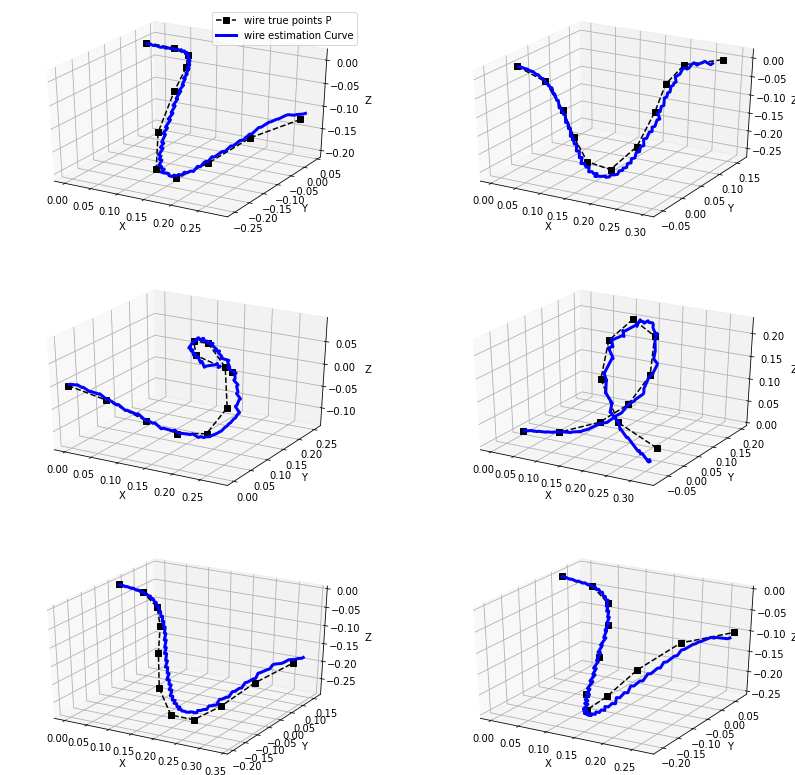

In [129]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(14,14))
for i in range(6):
  ax = fig.add_subplot(3,2,i+1,projection='3d')
  if i == 0:
    ax.plot(*Y_[indexes[i], :, :].T, color='k', ls='--', marker='s', label='wire true points P')
    ax.plot(*ps[i, :, :].T, color='b', ls='-', lw=3, label='wire estimation Curve')
    ax.legend()
  else:
    ax.plot(*Y_[indexes[i], :, :].T, color='k', ls='--', marker='s')
    ax.plot(*ps[i, :, :].T, color='b', ls='-', lw=3)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  
plt.savefig('./data/SAEC_plots.png')


plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Saved model: 0.024356044828891754
Saved model: 0.023869087919592857
Saved model: 0.02356100268661976
Saved model: 0.02334992215037346
Saved model: 0.023201558738946915
Saved model: 0.023097414523363113
Saved model: 0.023022642359137535
Saved model: 0.022968104109168053
Saved model: 0.02292824164032936
Saved model: 0.022900518029928207
Saved model: 0.02288636937737465
Saved model: 0.022880246862769127
Saved model: 0.022841287776827812
Saved model: 0.02281118370592594
Saved model: 0.022789064794778824
Saved model: 0.022772641852498055
Saved model: 0.022760402411222458
Saved model: 0.022751355543732643
Saved model: 0.022744720801711082
Saved model: 0.022739803418517113
Saved model: 0.02273600734770298
Saved model: 0.02273286134004593
Saved model: 0.022730043157935143
Saved model: 0.022727342322468758
Saved model: 0.02272464521229267
Saved model: 0.022721894085407257
Saved model: 0.022719064727425575
Saved model: 0.022716159000992775
Saved model: 0.022713175043463707
Saved model: 0.0227101

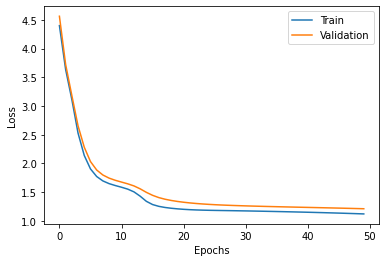

In [23]:
def run_sael():

    model = SAEL(loss_weight=config['sael_params']['loss_weight'], beta1=config['sael_params']['beta1'], 
                 beta2=config['sael_params']['beta2'], weight_decay=config['sael_params']['weight_decay'])
    # model = LAE(loss_weight=0.4)
    model = model.to(device)
    model, loss, train_losses, validate_losses = train_sae(model, train, train_a, validate, validate_a, lr=config['sael_params']['LR'])
    fig = plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(validate_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('./data/SAEL_train.png', dpi=1200)
    plt.show()

run_sael()

In [130]:
# test SAEL:

model_best = torch.load('check_point_SAEL.pt', map_location=device)

Acc = []
m_err = []
f_err = []
timer = []
# y = Y_test.squeeze().detach().numpy()

model_best = model_best.to('cpu')
for im in tqdm(range(X_test.shape[0])):
    # print('Processing rod conf. number %d.'%(im))
    a, p = X_test[im, :], Y_test[im, :, :].reshape((-1, 3))

    ts = time.time()
    with torch.no_grad():
        p_predict = model_best.decode(a.float().view(1, 6))
        timer.append(time.time() - ts)
        a_predict = model_best.encode(p.float().flatten())
        p_predict = p_predict.view(-1, 3)
        p_predict = p_predict.numpy()
        a_predict = a_predict.view(-1, 6)
        a_predict = a_predict.numpy()
    
    err = get_error(p, p_predict)
    Acc.append(np.mean(err))
    m_err.append(np.linalg.norm(scaler.inverse_transform(a_predict).squeeze()[:3] - scaler.inverse_transform(a.numpy().reshape(1, -1)).squeeze()[:3]))
    f_err.append(np.linalg.norm(scaler.inverse_transform(a_predict).squeeze()[3:] - scaler.inverse_transform(a.numpy().reshape(1, -1)).squeeze()[3:]))

accuracy = np.mean(Acc)
print(str(round(1000*accuracy, 4)) + '+-' + str(round(1000*np.std(Acc), 4)) + ' mm mean error')
print(str(round(np.mean(m_err), 4)) + '+-' + str(round(np.std(m_err), 4)) + ' Nm error')
print(str(round(np.mean(f_err), 4)) + '+-' + str(round(np.std(f_err), 4)) + ' N error')
print(str(round(1000*np.mean(timer), 4)) + '+-' + str(round(1000*np.std(timer), 4)) + ' msec')

  0%|          | 0/1179 [00:00<?, ?it/s]

31.0342+-15.3298 mm mean error
0.0425+-0.0358 Nm error
0.323+-0.2909 N error
0.3078+-0.5856 msec


In [131]:
ps=None
for ind in indexes:
    a, p, p_mark = X_test[ind, :], Y_test[ind, :, :].reshape((-1, 3)), Y_[ind, :, :].reshape((-1, 3))

    with torch.no_grad():
        p_predict = model_best.decode(a.float().view(1, 6))
        p_predict = p_predict.view(-1, 3)
        p_predict = p_predict.numpy()
        try:
          ps = np.concatenate((ps, p_predict.reshape(1, -1, 3)), axis=0)
        except:
          ps = p_predict.reshape(1, -1, 3)

ps.shape, Y_[indexes, :, :].shape

((6, 100, 3), (6, 11, 3))

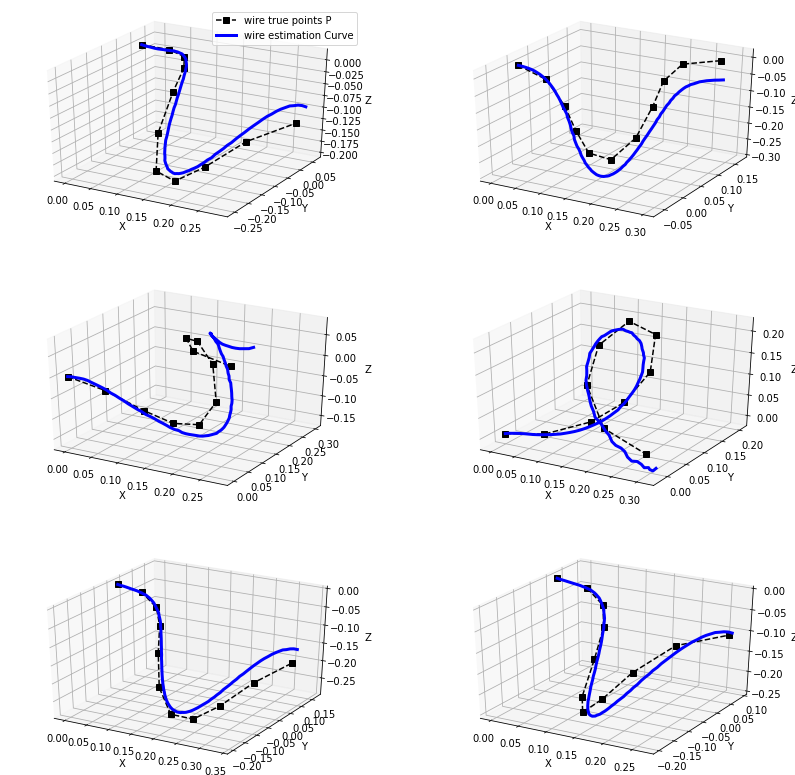

In [132]:
fig = plt.figure(figsize=(14,14))
for i in range(6):
  ax = fig.add_subplot(3,2,i+1,projection='3d')
  if i == 0:
    ax.plot(*Y_[indexes[i], :, :].T, color='k', ls='--', marker='s', label='wire true points P')
    ax.plot(*ps[i, :, :].T, color='b', ls='-', lw=3, label='wire estimation Curve')
    ax.legend()
  else:
    ax.plot(*Y_[indexes[i], :, :].T, color='k', ls='--', marker='s')
    ax.plot(*ps[i, :, :].T, color='b', ls='-', lw=3)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  
plt.savefig('./data/SAEL_plots.png')


plt.show()

# Implementing VAE and saving Latent space train data for INN:
---

  0%|          | 0/50 [00:00<?, ?it/s]

Saved model: 0.0013423016062006354
Validation Loss of epoch 0: 40.9250 mm
Saved model: 0.00043822595034725964
Validation Loss of epoch 1: 20.7159 mm
Saved model: 0.00031454337295144796
Validation Loss of epoch 2: 17.3340 mm
Saved model: 0.000282223365502432
Validation Loss of epoch 3: 16.6838 mm
Saved model: 0.00027229631086811423
Validation Loss of epoch 4: 16.4064 mm
Saved model: 0.00026317997253499925
Validation Loss of epoch 5: 16.1906 mm
Saved model: 0.0002577581908553839
Validation Loss of epoch 6: 16.1124 mm
Saved model: 0.0002565474424045533
Validation Loss of epoch 7: 16.0541 mm
Saved model: 0.00025083927903324366
Validation Loss of epoch 8: 16.0403 mm
Validation Loss of epoch 9: 15.9376 mm
Saved model: 0.00025031689438037574
Validation Loss of epoch 10: 15.8115 mm
Saved model: 0.0002428498410154134
Validation Loss of epoch 11: 15.8023 mm
Validation Loss of epoch 12: 15.6801 mm
Saved model: 0.00024077019770629704
Validation Loss of epoch 13: 15.6963 mm
Saved model: 0.000237708

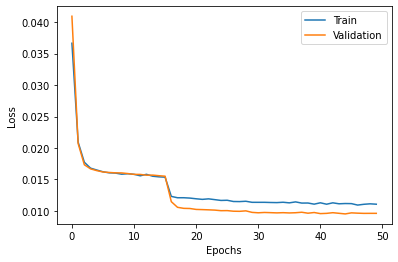

VAE2(
  (activation_latent): Identity()
  (activation): Tanh()
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(10, 1), stride=(10, 1))
      (1): Tanh()
    )
  )
  (fc_mu): Sequential(
    (0): Sequential(
      (0): Linear(in_features=480, out_features=480, bias=True)
      (1): Tanh()
      (2): Linear(in_features=480, out_features=480, bias=True)
      (3): Tanh()
      (4): Linear(in_features=480, out_features=6, bias=True)
      (5): Identity()
      (6): Linear(in_features=6, out_features=6, bias=True)
    )
  )
  (fc_mu1): Linear(in_features=6, out_features=6, bias=True)
  (fc_var): Linear(in_features=6, out_features=6, bias=True)
  (decoder_input): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=6, bias=True)
      (1): Identity()
      (2): Linear(in_features=6, out_features=480, bias=True)
      (3): Tanh()
      (4): Linear(in_features=480, out_features=480, bias=True)
    )
  )
  (decoder): Sequential(
    

In [25]:
def run_vae():
    model = VAE2()
    model = model.to(device)
    model, loss, train_losses, validate_losses = train_vae(model, train, train_a, validate, validate_a, lr=config['vae_params']['LR'])
    fig = plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(validate_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

run_vae()

In [30]:
vae2 = torch.load('check_point_VAE2.pt', map_location=device)
# vae = torch.load('check_point_VAE.pt', map_location='cpu')

In [31]:
with torch.no_grad():
  loss_ = []
  latent = []
  for (a_, y_) in zip(a, c):
      a_ = a_.float().to(device)
      y_ = y_.view(-1, config['model_params']['in_channels'], 100, 3).float().to(device)
      a_pred, log_ = vae2.encode(y_)
      # a_pred = vae.reparameterize(a_pred, log_)
      latent.append(a_pred.cpu().detach().numpy())

In [28]:
latent_data = np.array(latent).squeeze()

In [29]:
with open('data/latent_a.pkl', 'wb') as h:
  pickle.dump(
      (a, latent_data, c),
      h
  )